In [1]:
import ROOT
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import mplhep as hep

In [2]:
%%script false --no raise error
# Read files
with open("ttbar_file_complete.txt", "r") as f:
    files = [line.strip() for line in f if line.strip()]
    
    
tree_name = "Events"
df = ROOT.RDataFrame(tree_name, files)
print("Total entries:", df.Count().GetValue())

In [3]:
file = 'ttbar.root'
df = ROOT.RDataFrame("Events", file)

Warning in <TClass::Init>: no dictionary for class edm::Hash<1> is available
Warning in <TClass::Init>: no dictionary for class edm::ProcessHistory is available
Warning in <TClass::Init>: no dictionary for class edm::ProcessConfiguration is available
Warning in <TClass::Init>: no dictionary for class edm::ParameterSetBlob is available
Warning in <TClass::Init>: no dictionary for class pair<edm::Hash<1>,edm::ParameterSetBlob> is available


In [4]:
# Helper function that loops over jets and creates a vector of four vectors
make4vector = """
ROOT::RVec<ROOT::Math::PtEtaPhiMVector> Make4Vector(
ROOT::RVec<float> Jet_pt, 
ROOT::RVec<float> Jet_eta, 
ROOT::RVec<float> Jet_phi,
ROOT::RVec<float> Jet_mass){

ROOT::RVec<ROOT::Math::PtEtaPhiMVector> jets;
int nJets = Jet_pt.size();

for (int idx = 0; idx < nJets; idx++){
    auto jet = ROOT::Math::PtEtaPhiMVector(Jet_pt[idx], Jet_eta[idx], Jet_phi[idx], Jet_mass[idx]);
    jets.push_back(jet);
}
return jets;
}

"""

ROOT.gInterpreter.Declare(make4vector)

True

In [ ]:
FindHadrons = """
pair<ROOT::Math::PtEtaPhiMVector, ROOT::Math::PtEtaPhiMVector> FindDHadron(
ROOT::RVec<int> ParticleFlavour,
ROOT::RVec<int> MotherIdx,
ROOT::RVec<float> Jet_pt, 
ROOT::RVec<float> Jet_eta, 
ROOT::RVec<float> Jet_phi,
ROOT::RVec<float> Jet_mass
){

int nParticles = ParticleFlavour.size();
ROOT::RVec<ROOT::RVec<int>> ReturnVector;
float ReturnPt = 0;
int Return_pdgId;
std::vector<int> BMesons = {-511, -513, -521, -523, -531, -533};
std::vector<int> DMesons = {-411, -413, -421, -423, -431, -433};

// loop through every particle in event
for (int ii = 0; ii < nParticles; ii++){
    int Flavour = ParticleFlavour[ii];
}

}

"""

In [5]:
# Squared DeltaR function for jet and particle matching
DeltaR = """
Float_t DeltaR(Float_t eta1, Float_t eta2, Float_t phi1, Float_t phi2)
{    
    Float_t dEta = eta2 - eta1;
    Float_t dPhi = TVector2::Phi_mpi_pi(phi2 - phi1); // properly handle phi wrapping
    return pow(dEta, 2) + pow(dPhi, 2);
    }
"""
ROOT.gInterpreter.Declare(DeltaR)

True

In [ ]:
# Find corresponding reco jets for gen jets
# If the DeltaR is too large, returns a vector of (-1,-1,-1,-1)
JetMatch = """

ROOT::RVec <ROOT::Math::PtEtaPhiMVector> JetMatch(
ROOT::VecOps::RVec<ROOT::Math::PtEtaPhiMVector> GenEvent4Vector, 
ROOT::VecOps::RVec<ROOT::Math::PtEtaPhiMVector> RecoEvent4Vector)
{

    Int_t nJets = GenEvent4Vector.size();
    ROOT::RVec <ROOT::Math::PtEtaPhiMVector> ReturnVector(nJets, ROOT::Math::PtEtaPhiMVector(-1,-1,-1,-1)) ;

    //Storing Eta for finding the indices
    ROOT::RVec<ROOT::Math::PtEtaPhiMVector> RecoEvent = RecoEvent4Vector;
    ROOT::Math::PtEtaPhiMVector Cand4Vector;

    // Lambda function to remove the elements
    auto is_equal = [](const ROOT::Math::PtEtaPhiMVector& a, const ROOT::Math::PtEtaPhiMVector& b, double tol = 1e-5) {
    return (std::abs(a.Pt() - b.Pt()) < tol &&
            std::abs(a.Eta() - b.Eta()) < tol &&
            std::abs(a.Phi() - b.Phi()) < tol &&
            std::abs(a.M() - b.M()) < tol);
    };
    
    // Loop through GenJets
    for (int idxGen = 0; idxGen < nJets; idxGen++){

        ROOT::RVec <Float_t> dR(RecoEvent.size());
        // Loop through RecoJets
        for (int idxReco = 0; idxReco < RecoEvent.size(); idxReco++){
            dR[idxReco] = DeltaR(GenEvent4Vector[idxGen].Eta(), RecoEvent[idxReco].Eta(), GenEvent4Vector[idxGen].Phi(), RecoEvent[idxReco].Phi());
        }

        // Finding the minimum
        auto MinIdx = ROOT::VecOps::ArgMin(dR);
        Cand4Vector = RecoEvent[MinIdx];

        // Ensure that matching is proper with bound of DeltaR < 0.3
        if (dR[MinIdx] < 0.3){
            ReturnVector[idxGen] = Cand4Vector;

            // Remove the chosen vectors
            RecoEvent.erase(std::remove_if(RecoEvent.begin(), RecoEvent.end(),
                [&](const ROOT::Math::PtEtaPhiMVector& v) {
                    return is_equal(v, Cand4Vector);
                }), RecoEvent.end());

        }
        else{
            ReturnVector[idxGen] = ROOT::Math::PtEtaPhiMVector(-1,-1,-1,-1);
        }
    }
    return ReturnVector;
}
"""
ROOT.gInterpreter.Declare(JetMatch)


True

In [7]:
# The ill-matched jets are tagged with vector of -1
# The function removes all of them
RemoveJets = """
auto RemoveJets(
auto Jets,
ROOT::RVec <ROOT::Math::PtEtaPhiMVector> Condition
){
    auto ReturnVector = decltype(Jets){};
    for (int ii = 0; ii < Jets.size(); ii++){
        if (Condition[ii].Pt() != -1)
            ReturnVector.push_back(Jets[ii]);
    }
    return ReturnVector;
}
"""

ROOT.gInterpreter.Declare(RemoveJets)

True

In [8]:
# Finding b and gluons
# Takes specific flavour
Filter = """
ROOT::RVec <ROOT::Math::PtEtaPhiMVector> FilterFlavour(ROOT::RVec<ROOT::Math::PtEtaPhiMVector> CandVector, ROOT::RVec<Int_t> FlavourVector, Int_t Flavour)
{
    ROOT::RVec <ROOT::Math::PtEtaPhiMVector> FinalVector;

    for (int idx = 0; idx < FlavourVector.size(); idx++){
    
        // Choose only with specific flavour
        if (abs(FlavourVector[idx]) == Flavour){
            FinalVector.push_back( CandVector[idx]);
        }
    }
    return FinalVector;
}
"""

ROOT.gInterpreter.Declare(Filter)



True

In [ ]:
# Function to find B hadrons 
FindBHadron ="""
ROOT::RVec<ROOT::Math::PtEtaPhiMVector> FindBHadron(ROOT::RVec<int> FlavourID, ROOT::RVec<float> PartPt, ROOT::RVec<float> PartEta, ROOT::RVec<float> PartPhi, ROOT::RVec<float> PartM)
{
    ROOT::RVec <ROOT::Math::PtEtaPhiMVector> HadronVector;
    int nPart = FlavourID.size();

    // Loop through particles
    for (int idx = 0; idx < nPart; idx++){
        int CandVal = abs(FlavourID[idx]);

        // Check if the particle is B hadron
        if ((CandVal >= 500 && CandVal < 600) || (CandVal >= 5000 && CandVal < 6000)){
            ROOT::Math::PtEtaPhiMVector Hadron = ROOT::Math::PtEtaPhiMVector(PartPt[idx], PartEta[idx], PartPhi[idx], PartM[idx]);
            HadronVector.push_back(Hadron);
        }
    }
    return HadronVector;
}

"""

ROOT.gInterpreter.Declare(FindBHadron)

True

In [10]:
# Make 4 vector for gen jets from bottom quarks and b-hadrons
df= (df.Define("GenJet4Vector", "Make4Vector(GenJet_pt, GenJet_eta, GenJet_phi, GenJet_mass)")
      .Define("BHadron", "FindBHadron(GenPart_pdgId, GenPart_pt, GenPart_eta, GenPart_phi, GenPart_mass)")
      .Define("bGenJet4Vector", "FilterFlavour(GenJet4Vector, GenJet_partonFlavour, 5)"))

In [11]:
# Function to compute response
compute_R = """
ROOT::RVec<float> ComputeR(
ROOT::RVec<ROOT::Math::PtEtaPhiMVector> gen, 
ROOT::RVec<ROOT::Math::PtEtaPhiMVector> reco){
    
    ROOT::RVec<float> JESVector;
    
    for (int idx = 0; idx < gen.size(); idx++){
        float CandPt = reco[idx].Pt();
        float GenCandPt = gen[idx].Pt();
        if (CandPt > 0 || GenCandPt > 0){
            JESVector.push_back(CandPt / GenCandPt);
        }
    }
    return JESVector;
}
"""

ROOT.gInterpreter.Declare(compute_R)

True

In [12]:
# Arrange BHadrons to correspond nearest jet from it and compute fragmentation
df = (df.Redefine("BHadron", "JetMatch(bGenJet4Vector, BHadron)")
        .Define("xB", "ComputeR(bGenJet4Vector, BHadron)" ))

/var/folders/s6/9r2gng9n28jfv8k1p2d_82rr0000gn/T/ipykernel_67770/1088800265.py:40: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


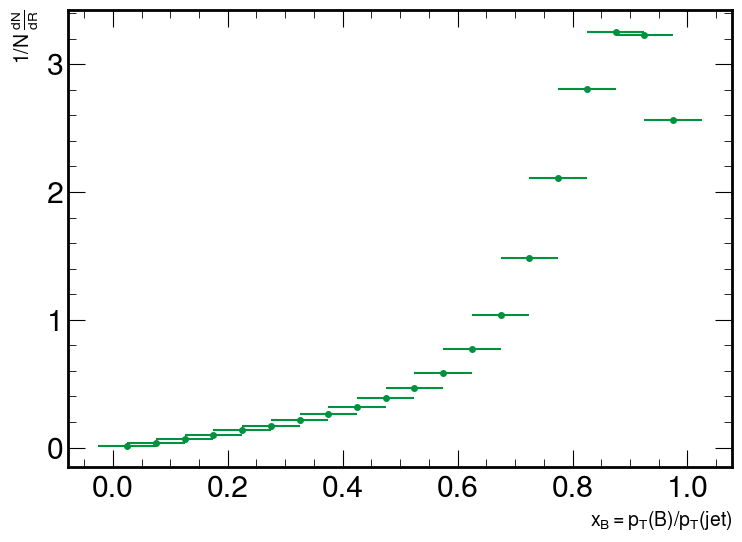

In [13]:
# Plot fragmentation with 20 bins
had_hist = df.Histo1D(("x(B)", "Hadron response x(B) = pt(B)/pt(bjet);Response;N;", 20, 0,1), "xB")

hep.style.use("CMS")

# Extract ROOT.TH1
hist = had_hist.GetValue()
n_bins = hist.GetNbinsX()

# Bin values
counts = np.array([hist.GetBinContent(i+1) for i in range(n_bins)])
edges  = np.array([hist.GetBinLowEdge(i+1) for i in range(n_bins)] + [hist.GetBinLowEdge(n_bins+1)])
bin_centers = np.array([hist.GetBinCenter(i+1) for i in range(n_bins)])
bin_widths  = np.array([hist.GetBinWidth(i+1) for i in range(n_bins)])

# Total number of entries
N_total = hist.Integral()

# Normalized bin heights (1/N * dN/dR)
counts_norm = counts / (N_total * bin_widths)

# Statistical errors (normalized)
errors = np.sqrt(counts) / (N_total * bin_widths)

# CMS green color
cms_green = "#00923f"

# Plot with error bars
fig, ax = plt.subplots(figsize=(8,6))

ax.errorbar(
    bin_centers, counts_norm,
    xerr=bin_widths, yerr=errors,
    fmt='o', color=cms_green, markersize=4,  # smaller dots + CMS green
)

ax.set_xlabel(r"$x_B = p_T(B)/p_T(jet)$", fontsize=14)
ax.set_ylabel(r"$1/N \; \frac{dN}{dR}$", fontsize=14)

ax.legend()
plt.tight_layout()
plt.show()


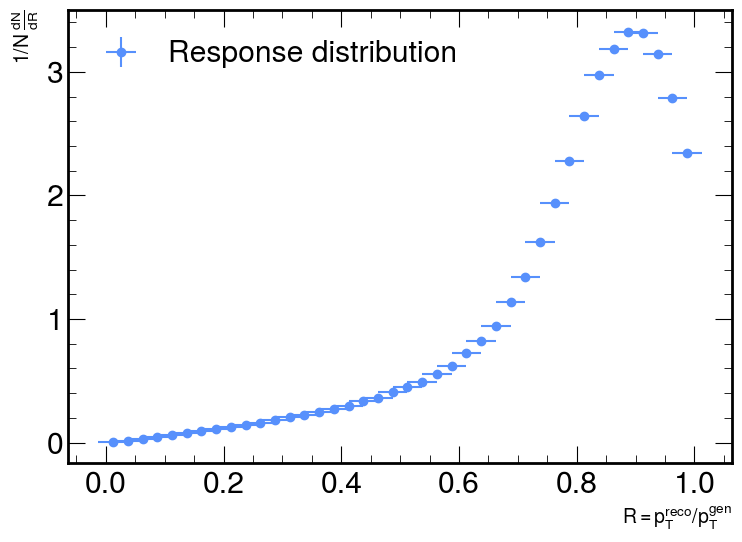

In [14]:
# Plot fragmentation with 40 bins
had_hist = df.Histo1D(("x(B)", "Hadron response x(B) = pt(B)/pt(bjet);Response;N;", 40, 0,1), "xB")

hep.style.use("CMS")

# Extract ROOT.TH1
hist = had_hist.GetValue()
n_bins = hist.GetNbinsX()

# Bin values
counts = np.array([hist.GetBinContent(i+1) for i in range(n_bins)])
edges  = np.array([hist.GetBinLowEdge(i+1) for i in range(n_bins)] + [hist.GetBinLowEdge(n_bins+1)])
bin_centers = np.array([hist.GetBinCenter(i+1) for i in range(n_bins)])
bin_widths  = np.array([hist.GetBinWidth(i+1) for i in range(n_bins)])

# Total number of entries
N_total = hist.Integral()

# Normalized bin heights (1/N * dN/dR)
counts_norm = counts / (N_total * bin_widths)

# Statistical errors (normalized)
errors = np.sqrt(counts) / (N_total * bin_widths)

# Plot with error bars
fig, ax = plt.subplots(figsize=(8,6))

ax.errorbar(
    bin_centers, counts_norm, xerr=bin_widths, yerr=errors,
    fmt='o', color="C0", label="Response distribution"
)

ax.set_xlabel(r"$R = p_{T}^{\mathrm{reco}} / p_{T}^{\mathrm{gen}}$", fontsize=14)
ax.set_ylabel(r"$1/N \; \frac{dN}{dR}$", fontsize=14)

ax.legend()
plt.tight_layout()
plt.show()
